In [95]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import jax
device = jax.default_backend()
device_amount = jax.local_device_count()
print(device, device_amount)

gpu 1


In [69]:
df = pd.read_csv('../data/player_stats_trends.csv')
tournament_stats = pd.read_csv('../data/tournament_stats.csv')
goals = pd.read_csv('../data/goals.csv')
awards = pd.read_csv('../data/awards.csv')

In [70]:
awards['Year'] = awards['Season'].apply(lambda x: float(str(x)[-2:]))
awards = awards.drop(columns=['Season', 'Club/Country'])
awards = awards.groupby('Award').filter(lambda x: len(x) >= 5)
awards = awards[~awards['Award'].isin(["Winner Ballon d'Or", 'Footballer of the Year', 'UEFA Best Player in Europe', "The Best FIFA Men's Player", 'Player of the Year', 'Top goal scorer', 'African Footballer of the Year', 'TM-Player of the season'])]


awards = pd.get_dummies(awards, columns=['Award'], prefix='', prefix_sep='')

for col in awards.columns:
    if col not in ['Player', 'Year']:
        awards[col] = awards[col].astype(int)
awards = awards.groupby(['Player', 'Year']).sum().reset_index()


In [71]:
def goal_fixer(goals):
    try:
        return int(goals)
    except:
        return 0
def run_model(X, y):
    glm = sm.GLM(endog=y, exog= X, family=sm.families.Gaussian())
    X = sm.add_constant(X)
    glm_results = glm.fit()
    return glm_results
def remove_p(X, glm_results, p):
    to_remove = []
    for i in glm_results.pvalues.index:
        if glm_results.pvalues[i] > p:
            to_remove.append(i)
        elif np.isnan(glm_results.pvalues[i]):
            to_remove.append(i)
    X = X.drop(columns=to_remove)
    return X

In [72]:
tournament_stats['Year'] = tournament_stats['Season'].apply(lambda x: float(x[-2:]))
tournament_stats = tournament_stats.drop('Season', axis=1)
tournament_stats = tournament_stats.query('Year >= 8 & Year <= 23')
tournament_stats['Goals'] = tournament_stats['Goals'].apply(lambda x: goal_fixer(x))
tournament_stats['Minutes played'] = tournament_stats['Minutes played'].apply(lambda x: goal_fixer(x))

comp_goals = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Goals'].replace(np.nan, 0).reset_index()
comp_goals = comp_goals.rename(columns=lambda x: x + '_Goals')
comp_goals.rename(columns={'Year_Goals': 'Year', 'Player_Goals' : 'Player'}, inplace=True)

Goals = []
for i in comp_goals.iterrows():
    rs = 0
    for j in i[1].index:
        if j not in ['Player', 'Year']:
            rs += i[1][j]
    Goals.append(rs)
comp_goals['Goals'] = Goals

comp_mins = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Minutes played'].replace(np.nan, 0).reset_index()
comp_mins = comp_mins.rename(columns=lambda x: x + '_Minutes')
comp_mins.rename(columns={'Year_Minutes': 'Year', 'Player_Minutes' : 'Player'}, inplace=True)

In [73]:
df = df.drop(columns=['P1', 'P2', 'P3', 'P4', 'P5', 'Votes', 
                      'RankPts', 'Percent', 'Voted', 'Season',
                      'Goals', 'Rank', 'Club', 'Nationality', 
                      'Points', 'Minutes played', 'Sesond yellow cards'])

In [74]:
for i in df.columns:
    if i  not in ['Player', 'Nationality', 'Club']:
        df[i] = df[i].astype(float)

In [75]:
df = df.merge(comp_goals, on=['Year', 'Player'], how='left')
df = df.merge(awards, on=['Year', 'Player'], how='left')
df = df.merge(comp_mins, on=['Year', 'Player'], how='left')
# dfs = []
# for i in range(8, 24):
#     scaler = MinMaxScaler()
#     if  i == 20:
#         continue
#     df_temp = df.query('Year == @i')
#     df_temp['Goals_Scaled'] = scaler.fit_transform(df_temp['Goals'].values.reshape(-1, 1))
#     dfs.append(df_temp)
# df = pd.concat(dfs)

df.fillna(0, inplace=True)
df = df.groupby(['Player', 'Year']).sum()

In [77]:
df = df[['Goals conceded', 'Champions League_Goals', 'Championship_Goals', 
'LaLiga_Goals', 'Premier League_Goals', 'Supercopa_Goals', 'Champions League winner', 
'European champion', 'Olympic medalist', 'World Cup winner',
 'Share']]

In [78]:
df

Goals conceded  Champions League_Goals  \
Player             Year                                           
Alexis Sánchez     15.0             0.0                     3.0   
Alisson            18.0            19.0                     0.0   
Andrea Pirlo       13.0             0.0                     0.0   
Andrei Arshavin    8.0              0.0                     0.0   
                   9.0              0.0                     0.0   
...                                 ...                     ...   
Zlatan Ibrahimović 15.0             0.0                     2.0   
                   16.0             0.0                     5.0   
Ángel Di María     14.0             0.0                     3.0   
Éric Abidal        11.0             0.0                     0.0   
İlkay Gündoğan     23.0             0.0                     1.0   

                         Championship_Goals  LaLiga_Goals  \
Player             Year                                     
Alexis Sánchez     15.0                 0.0           0.0   
Alisson            18.0                 0.0           0.0   
Andrea Pirlo       13.0                 0.0           0.0   
Andrei Arshavin    8.0                  0.0           0.0   
                   9.0                  0.0           0.0   
...                                     ...           ...   
Zlatan Ibrahimović 15.0                 0.0           0.0   
                   16.0                 0.0           0.0   
Ángel Di María     14.0                 0.0           4.0   
Éric Abidal        11.0                 0.0           0.0   
İlkay Gündoğan     23.0                 0.0           0.0   

                         Premier League_Goals  Supercopa_Goals  \
Player             Year                                          
Alexis Sánchez     15.0                  16.0              0.0   
Alisson            18.0                   0.0              0.0   
Andrea Pirlo       13.0                   0.0              0.0   
Andrei Arshavin    8.0                    0.0              0.0   
                   9.0                    6.0              0.0   
...                                       ...              ...   
Zlatan Ibrahimović 15.0                   0.0              0.0   
                   16.0                   0.0              0.0   
Ángel Di María     14.0                   0.0              0.0   
Éric Abidal        11.0                   0.0              0.0   
İlkay Gündoğan     23.0                   8.0              0.0   

                         Champions League winner  European champion  \
Player             Year                                               
Alexis Sánchez     15.0                      0.0                0.0   
Alisson            18.0                      0.0                0.0   
Andrea Pirlo       13.0                      0.0                0.0   
Andrei Arshavin    8.0                       0.0                0.0   
                   9.0                       0.0                0.0   
...                                          ...                ...   
Zlatan Ibrahimović 15.0                      0.0                0.0   
                   16.0                      0.0                0.0   
Ángel Di María     14.0                      1.0                0.0   
Éric Abidal        11.0                      1.0                0.0   
İlkay Gündoğan     23.0                      1.0                0.0   

                         Olympic medalist  World Cup winner   Share  
Player             Year                                              
Alexis Sánchez     15.0               0.0               0.0  0.0114  
Alisson            18.0               0.0               0.0  0.0007  
Andrea Pirlo       13.0               0.0               0.0  0.0111  
Andrei Arshavin    8.0                0.0               0.0  0.0444  
                   9.0                0.0               0.0  0.0035  
...                                   ...               ...     ...  
Zlatan Ibrahimov

In [79]:
train = df.query('Year < 23')
test = df.query('Year == 23')
# train.set_index(['Player', 'Year'], inplace=True)
# test.set_index(['Player', 'Year'], inplace=True)

X_train, y_train = train.drop(columns=['Share']), train['Share']
X_test, y_test = test.drop(columns=['Share']), test['Share']


In [80]:
X_train

Goals conceded  Champions League_Goals  \
Player             Year                                           
Alexis Sánchez     15.0             0.0                     3.0   
Alisson            18.0            19.0                     0.0   
Andrea Pirlo       13.0             0.0                     0.0   
Andrei Arshavin    8.0              0.0                     0.0   
                   9.0              0.0                     0.0   
...                                 ...                     ...   
Zlatan Ibrahimović 14.0             0.0                    10.0   
                   15.0             0.0                     2.0   
                   16.0             0.0                     5.0   
Ángel Di María     14.0             0.0                     3.0   
Éric Abidal        11.0             0.0                     0.0   

                         Championship_Goals  LaLiga_Goals  \
Player             Year                                     
Alexis Sánchez     15.0                 0.0           0.0   
Alisson            18.0                 0.0           0.0   
Andrea Pirlo       13.0                 0.0           0.0   
Andrei Arshavin    8.0                  0.0           0.0   
                   9.0                  0.0           0.0   
...                                     ...           ...   
Zlatan Ibrahimović 14.0                 0.0           0.0   
                   15.0                 0.0           0.0   
                   16.0                 0.0           0.0   
Ángel Di María     14.0                 0.0           4.0   
Éric Abidal        11.0                 0.0           0.0   

                         Premier League_Goals  Supercopa_Goals  \
Player             Year                                          
Alexis Sánchez     15.0                  16.0              0.0   
Alisson            18.0                   0.0              0.0   
Andrea Pirlo       13.0                   0.0              0.0   
Andrei Arshavin    8.0                    0.0              0.0   
                   9.0                    6.0              0.0   
...                                       ...              ...   
Zlatan Ibrahimović 14.0                   0.0              0.0   
                   15.0                   0.0              0.0   
                   16.0                   0.0              0.0   
Ángel Di María     14.0                   0.0              0.0   
Éric Abidal        11.0                   0.0              0.0   

                         Champions League winner  European champion  \
Player             Year                                               
Alexis Sánchez     15.0                      0.0                0.0   
Alisson            18.0                      0.0                0.0   
Andrea Pirlo       13.0                      0.0                0.0   
Andrei Arshavin    8.0                       0.0                0.0   
                   9.0                       0.0                0.0   
...                                          ...                ...   
Zlatan Ibrahimović 14.0                      0.0                0.0   
                   15.0                      0.0                0.0   
                   16.0                      0.0                0.0   
Ángel Di María     14.0                      1.0                0.0   
Éric Abidal        11.0                      1.0                0.0   

                         Olympic medalist  World Cup winner  
Player             Year                                      
Alexis Sánchez     15.0               0.0               0.0  
Alisson            18.0               0.0               0.0  
Andrea Pirlo       13.0               0.0               0.0  
Andrei Arshavin    8.0                0.0               0.0  
                   9.0                0.0               0.0  
...                                   ...               ...  
Zlatan Ibrahimović 14.0               0.0               0.0  
                  

In [94]:
import pymc as pm

from pymc import Normal, HalfNormal, HalfCauchy

n_vars = X_train.shape[1]
n_obs = X_train.shape[0]
print(n_vars)

with pm.Model() as bayes_model:
    sigma = HalfCauchy('sigma', np.repeat(10, n_obs))
    alpha = Normal('alpha', mu=np.repeat(0, n_vars), sigma=np.repeat(100, n_vars))
    beta = HalfNormal('beta', sigma=np.repeat(100, n_vars, axis=0))
    
    
    X = pm.Data("predictors", X_train, mutable=True)
    
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))
    print(mu.eval().shape)
    print(sigma.eval().shape)
    
    y = Normal('prediction', mu=mu, sigma=sigma, observed=y_train)
    
    if device == "gpu":
        trace_mlr = pm.sample(1000, nuts_sampler="numpyro")
    else:
        trace_mlr = pm.sample(4000)
    

10
(333,)
(333,)


Compiling...
/home/thejarmanitor/miniconda3/envs/outplayed/lib/python3.10/site-packages/pymc/sampling/jax.py:678: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:01.305315
Sampling...
sample: 100%|██████████| 2000/2000 [01:52<00:00, 17.76it/s, 26 steps of size 2.13e-02. acc. prob=0.79] 
Sampling time = 0:06:38.907585
Transforming variables...
Transformation time = 0:00:00.174216


In [96]:
import arviz as az

az.summary(trace_mlr, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],3.138,101.351,-173.435,201.209,3.768,2.683,725.0,918.0,1.01
alpha[1],4.292,98.769,-204.053,174.952,3.468,2.643,820.0,999.0,1.01
alpha[2],1.808,101.393,-195.658,185.711,3.696,2.615,755.0,710.0,1.00
alpha[3],3.016,97.299,-171.237,190.393,3.553,2.513,752.0,1160.0,1.00
alpha[4],-6.127,98.033,-193.523,168.458,3.386,2.395,844.0,849.0,1.00
alpha[5],0.829,103.883,-192.681,201.953,3.736,2.704,774.0,971.0,1.01
alpha[6],-1.263,99.854,-184.009,189.966,4.091,2.894,598.0,418.0,1.01
alpha[7],4.857,95.307,-176.628,184.874,3.576,2.705,711.0,822.0,1.01
alpha[8],3.397,97.601,-164.852,196.448,3.612,2.937,753.0,850.0,1.01
alpha[9],-1.524,100.224,-184.821,197.401,3.899,2.845,664.0,394.0,1.01


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

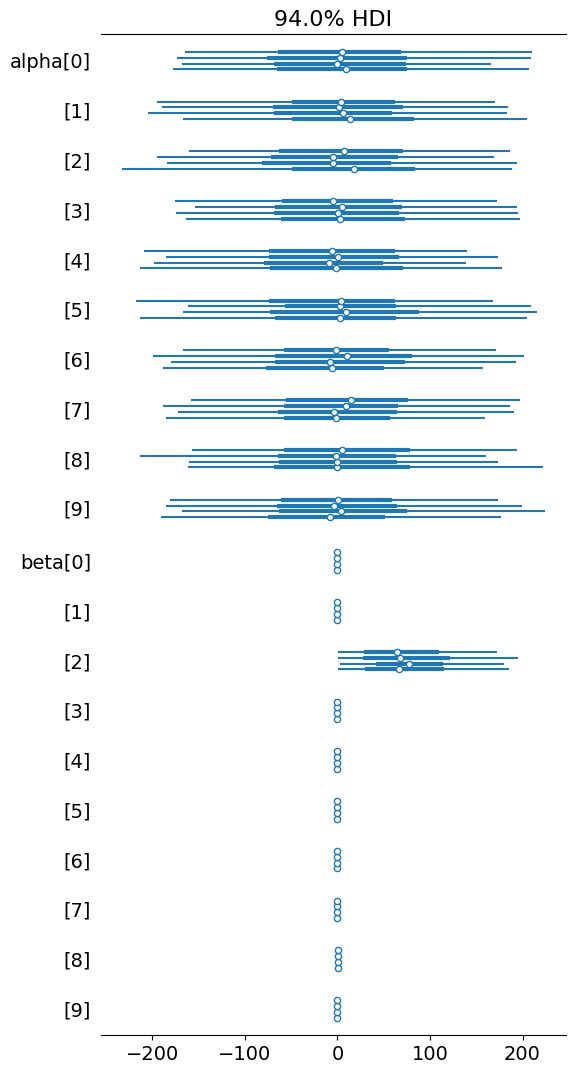

In [97]:
az.plot_forest(trace_mlr, var_names=["alpha","beta"])

array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n1'}>,
        <Axes: title={'center': 'alpha\n2'}>,
        <Axes: title={'center': 'alpha\n3'}>],
       [<Axes: title={'center': 'alpha\n4'}>,
        <Axes: title={'center': 'alpha\n5'}>,
        <Axes: title={'center': 'alpha\n6'}>,
        <Axes: title={'center': 'alpha\n7'}>],
       [<Axes: title={'center': 'alpha\n8'}>,
        <Axes: title={'center': 'alpha\n9'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>,
        <Axes: title={'center': 'beta\n8'}>,
        <Axes: title={'center': 'beta\n9'}>]], dtype=object)

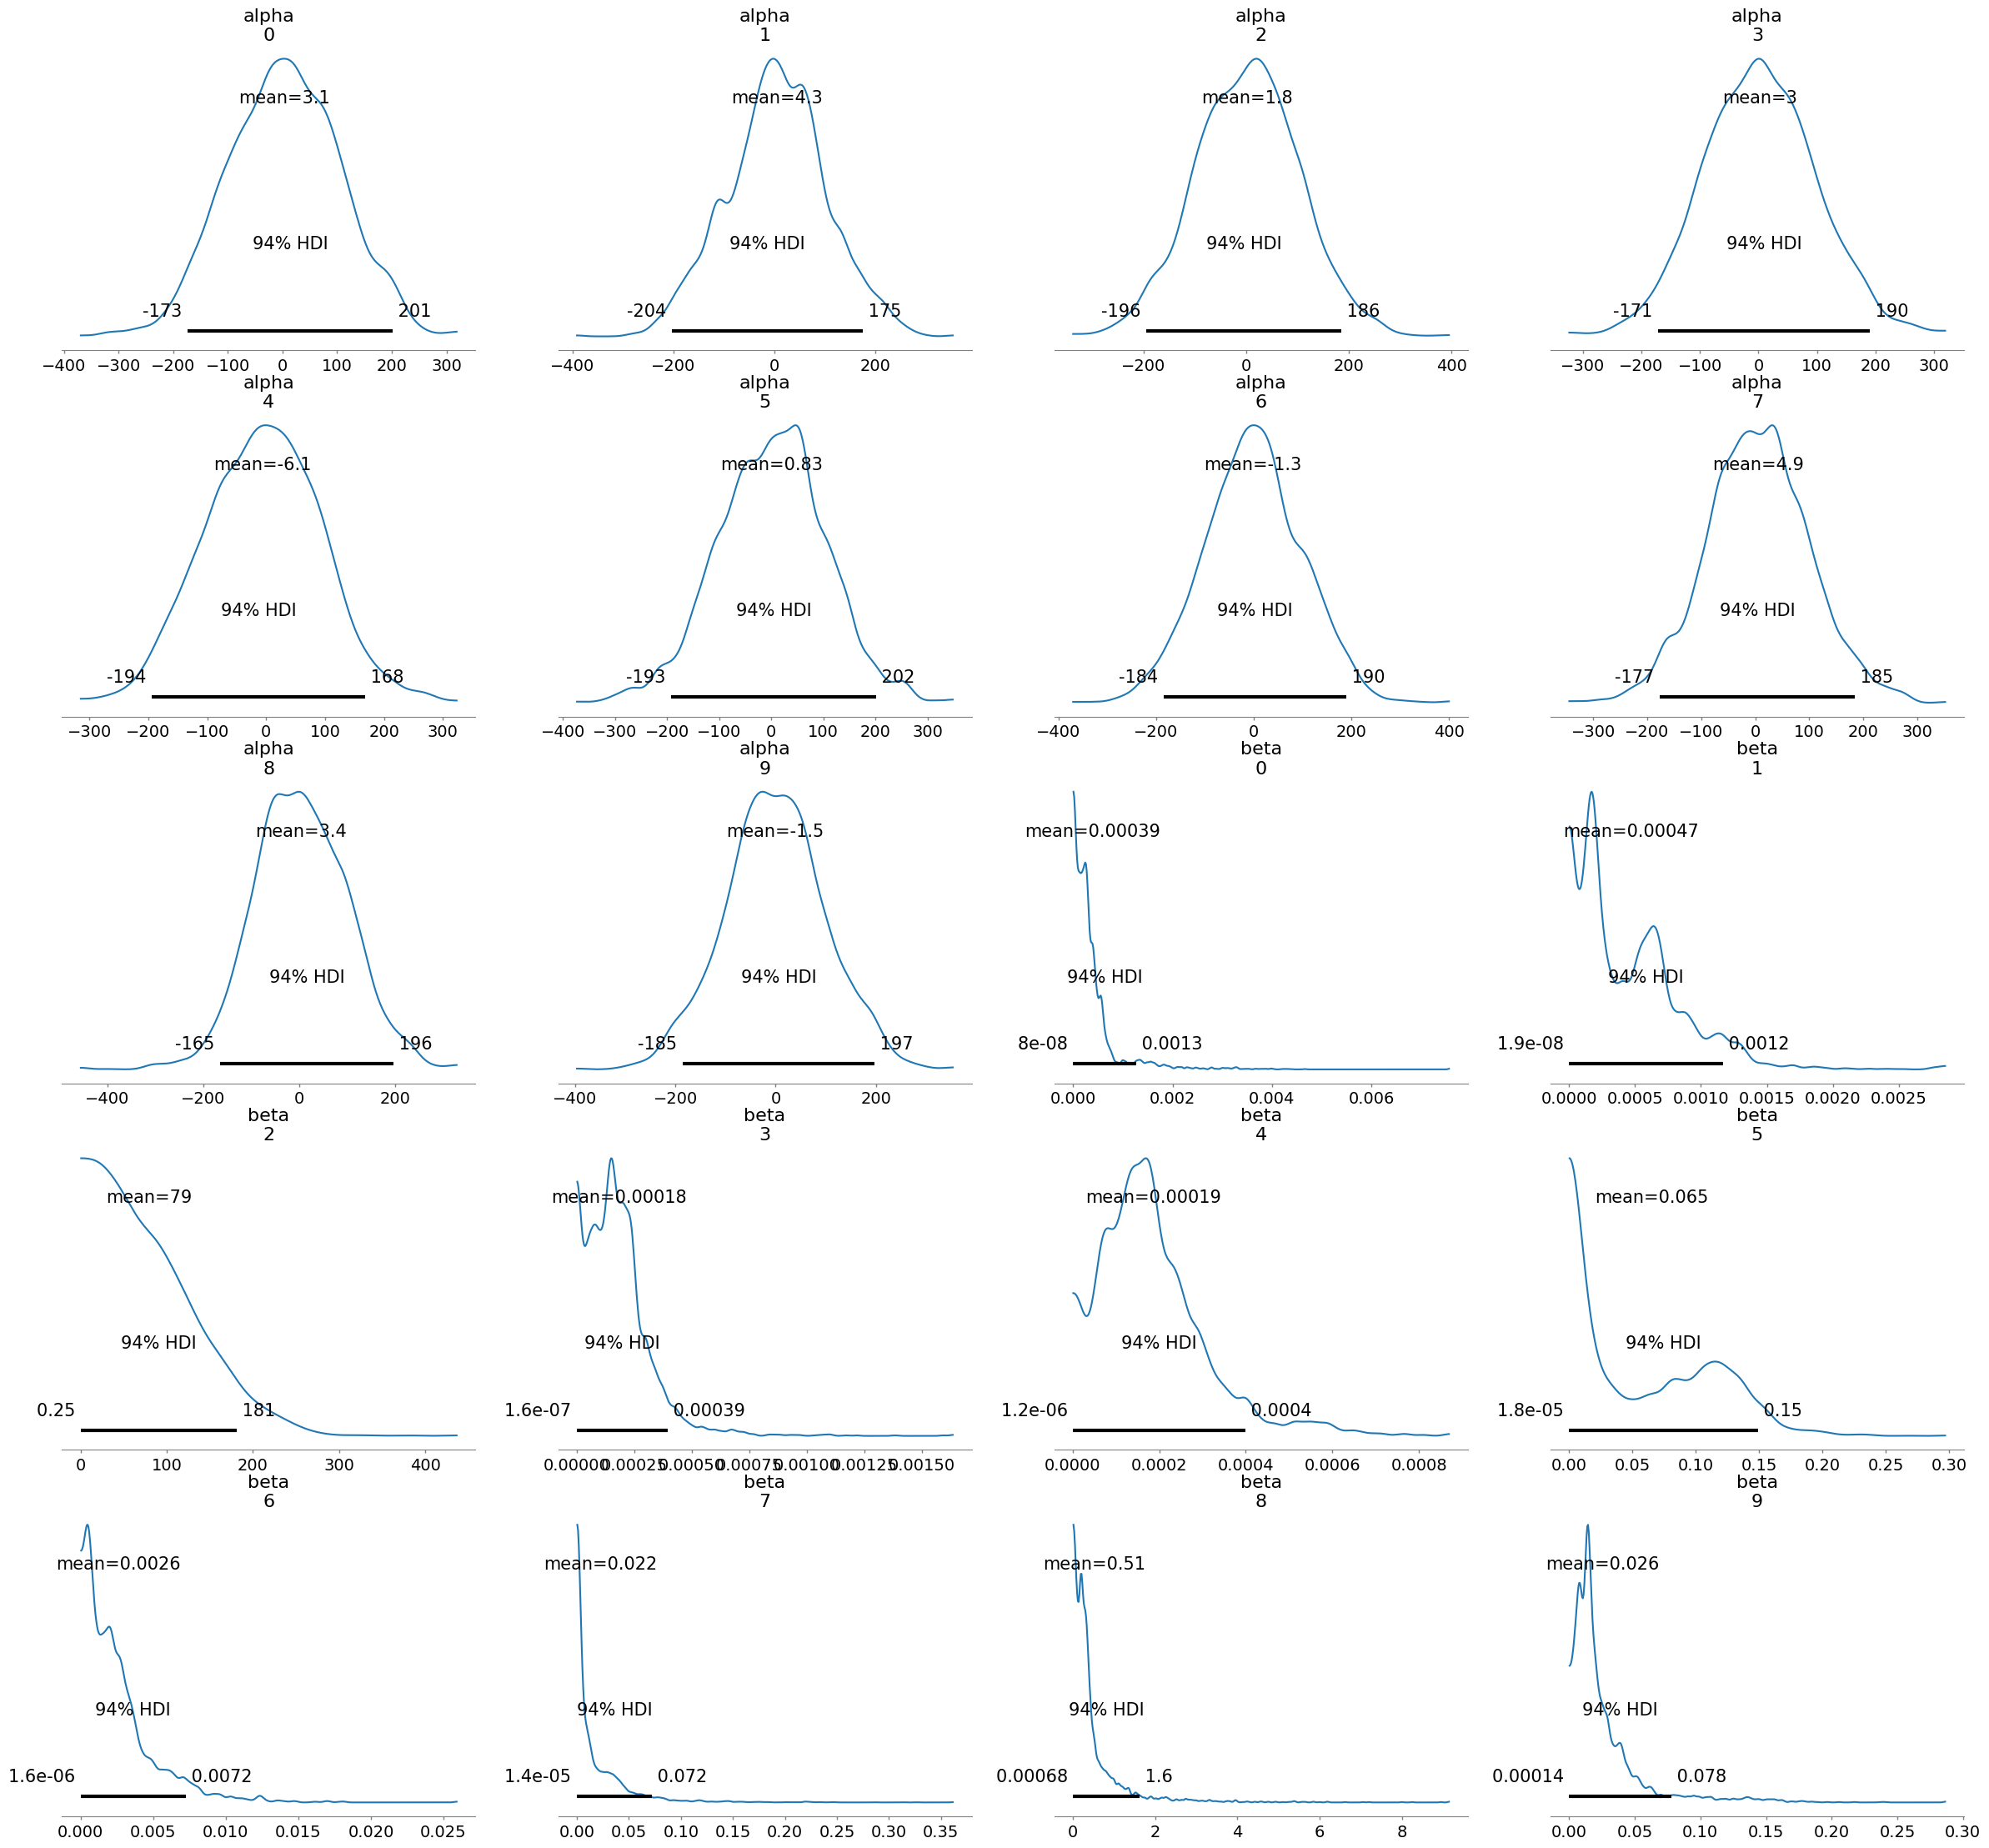

In [98]:
az.plot_posterior(trace_mlr, var_names=["alpha","beta"])

In [103]:
with bayes_model:
    pm.set_data({"predictors": X_test})
    trace_mlr_pred = pm.sample_posterior_predictive(
        trace_mlr,
        var_names=["mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
    )

Sampling: []


In [108]:
y_test.shape

(29,)

In [113]:
trace_mlr_pred

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

<xarray.DataArray 'predictors' (predictors_dim_0: 29, predictors_dim_1: 10)>
array([[11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0., 15.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  4.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 12.,  0.,  0., 36.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  9.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  4.,  0., 19.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  7.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0., 19.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0., 23.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  7.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.],
       [17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  8.,  0.,  1.,  0.,  0.,  0.]])
Coordinates:
  * predictors_dim_0  (predictors_dim_0) int64 0 1 2 3 4 5 ... 23 24 25 26 27 28
  * predictors_dim_1  (predictors_dim_1) int64 0 1 2 3 4 5 6 7 8 9

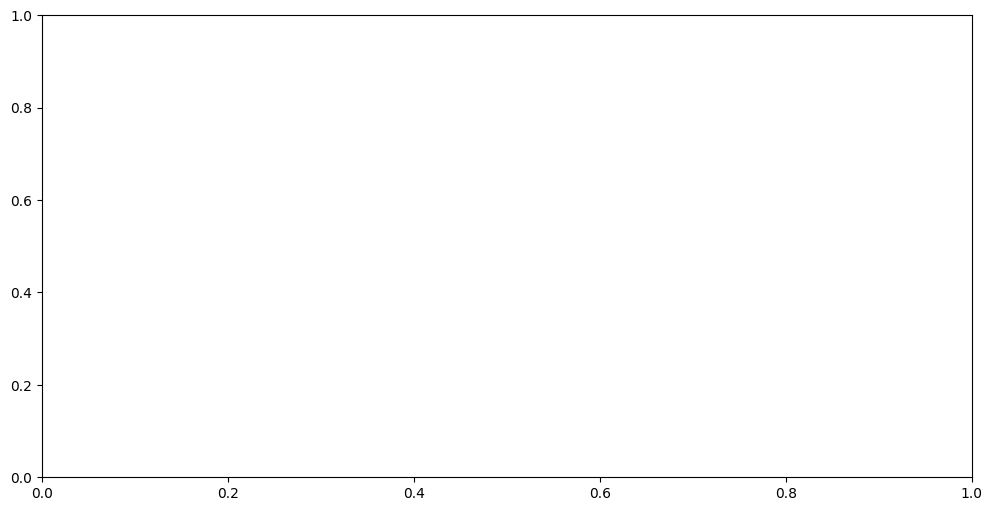

In [116]:
_, ax = plt.subplots(figsize=(12, 6))


# model_preds = trace_mlr_pred.predictions

preds_out_of_sample